# Demonstration of MuPT molecular representation for simple tripeptides

In [13]:
from networkx import path_graph
from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule, Compute2DCoords

from mupt.geometry.shapes import PointCloud
from mupt.mupr.primitives import Primitive, PrimitiveHandle
from mupt.mupr.topology import TopologicalStructure

from mupt.mutils.iteration import sliding_window
from mupt.interfaces.rdkit import primitive_from_rdkit, primitive_to_rdkit
from mupt.chemistry.peptide import AMINO_ACIDS_BY_FASTA, AminoAcidSubstructure


sequence : str = 'WLC' #'AFCH'

# assemble peptide molecule from amino acid fragments
molecule_prim = Primitive(label='Molecule')
frag_attrs : list[str] = ['fragment_term_N'] + ['fragment_middle']*(len(sequence)-2) + ['fragment_term_O']

path : list[PrimitiveHandle] = []
for frag_attr, letter in zip(frag_attrs, sequence):
    amino_acid : AminoAcidSubstructure = AMINO_ACIDS_BY_FASTA[letter]
    
    fragmol : Chem.Mol = getattr(amino_acid, frag_attr)()
    # DEV: temporary while more nuanced molecule sanitization settings get propagated throughout toolkit
    Chem.Kekulize(fragmol, clearAromaticFlags=True)
    Chem.SetAromaticity(fragmol, Chem.AROMATICITY_MDL)
    conf_id = Compute2DCoords(fragmol)
    # display(fragmol)
    
    resprim : Primitive = primitive_from_rdkit(fragmol, label=amino_acid.ccd_code, sanitize_frags=False, conformer_idx=conf_id)
    resprim_handle : PrimitiveHandle = molecule_prim.attach_child(resprim)
    path.append(resprim_handle)
molecule_prim.set_topology(path_graph(path, create_using=TopologicalStructure))

## align neighboring fragments
for conn_ref1, conn_ref2 in molecule_prim.internal_connections:
    conn1 = molecule_prim.fetch_connector_on_child(conn_ref1)
    conn2 = molecule_prim.fetch_connector_on_child(conn_ref2)
    prim2 = molecule_prim.fetch_child(conn_ref2.primitive_handle)
    
    prim2.rigidly_transform(conn2.rigid_antialignment_to(conn1))
    
# insert peptide molecule into universe
universe_prim = Primitive(label='Universe')
peptide_handle = universe_prim.attach_child(molecule_prim)

Attempting to infer internal connections automatically from given topology; user should verify the connections assigned make sense!


## Visualizing Primitive Hierarchy

In [15]:
import matplotlib.pyplot as plt
%matplotlib ipympl
from matplotlib.colors import rgb2hex
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import networkx as nx
from anytree.iterators import LevelOrderGroupIter


def topology_to_positions(
    top : nx.Graph,
    level_idx : int=0,
    layout_fn=nx.kamada_kawai_layout,
):
    node_positions = np.zeros((len(top), 3), dtype=float)
    node_positions[:, -1] = level_idx
    
    node_map = {node : i for i, node in enumerate(top.nodes)}
    pos = layout_fn(top)
    for node, position in pos.items():
        node_idx = node_map[node]
        node_positions[node_idx, :-1] = position
        
    edge_lines = [
        node_positions[ [node_map[node1], node_map[node2]] ]
            for (node1, node2) in top.edges
    ]
    return node_positions, edge_lines

def uniform_spacing_about_origin(n : int, scale : float=1.0) -> np.ndarray:
    mean_pos = (n - 1)*scale/2
    
    return np.arange(n, dtype=float)*scale - mean_pos

In [16]:
# configure drawing options here
eps = 0.05
scale : float = 10
cmap = plt.get_cmap('Accent')

plot_arrows : bool = True
# plot_arrows : bool = False
arrow_ratio : float = 0.1
arrow_color : str = 'grey'

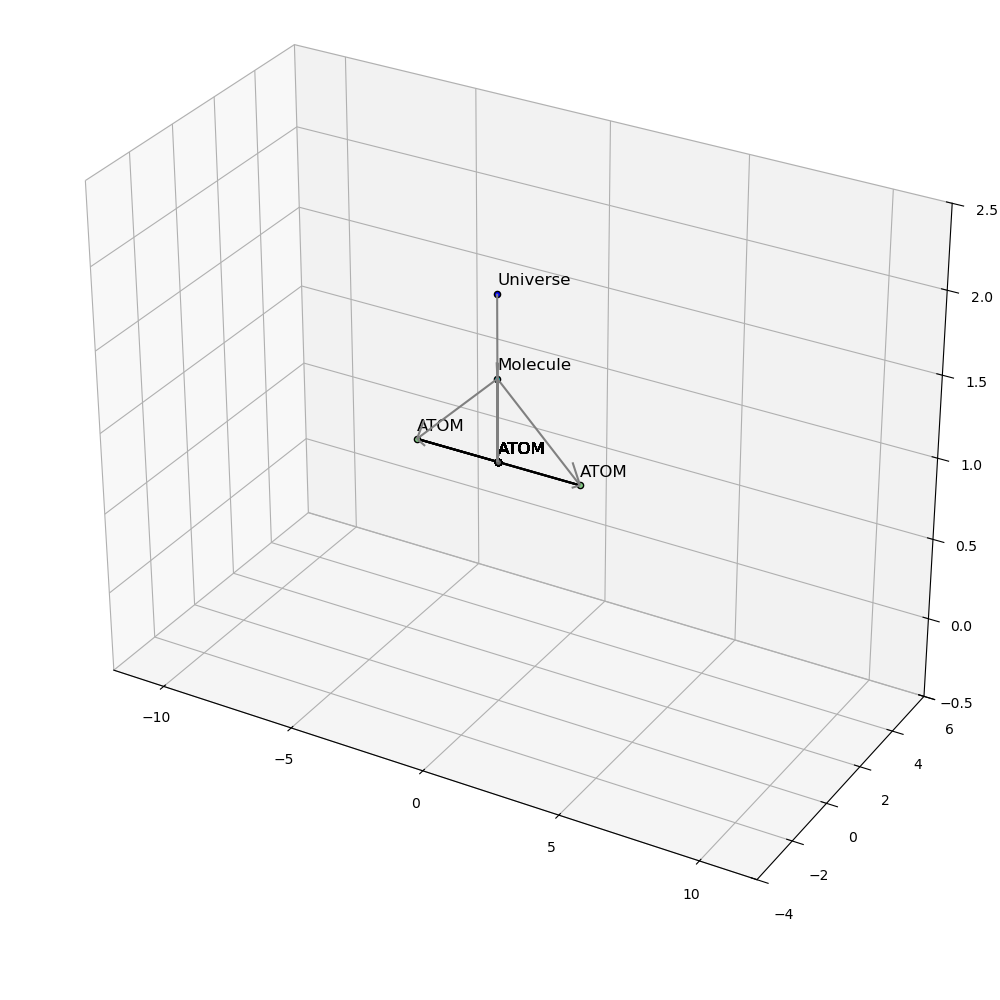

In [20]:

z_eps = np.array([0.0, 0.0, eps])
n_rows, n_cols = 1, 1
aspect = n_cols / n_rows
figsize = (aspect*scale, scale)

fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': '3d'})
ax.autoscale('off')
# ax.grid(False)
ax.grid(True)
# ax.axis('off')

ax.set_xlim(-12, 12)
ax.set_ylim(-4, 6)
ax.set_zlim(-0.5, 2.5)

ax.elev = 30
ax.azim = -60
ax.roll = 0

# ax.get_proj = lambda : np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.7, 1]))

# plot universe
universe_pos = np.array([0, 0, 2], dtype=float)
ax.scatter(*universe_pos, marker='o', edgecolor='k', color='b')
ax.text(*(universe_pos + z_eps), universe_prim.label, fontsize=12)

# plot mol
mol_pos = np.array([0, 0, 1.5], dtype=float)
ax.scatter(*mol_pos, marker='o', edgecolor='k', color='c')
ax.text(*(mol_pos + z_eps), molecule_prim.label, fontsize=12)
if plot_arrows:
    ax.quiver(*universe_pos, *mol_pos - universe_pos, color=arrow_color, arrow_length_ratio=0.2)

# plot residues
res_pos_x = uniform_spacing_about_origin(len(sequence), scale=3)
node_pos_residue, edge_pos_residue = topology_to_positions(
    molecule_prim.topology,
    level_idx=1.0,
    layout_fn=lambda top : {handle : (-x_pos, 0) for handle, x_pos in zip(molecule_prim.children_by_handle.keys(), res_pos_x)},
)
# add edges and arrows for residue
for edgepair in edge_pos_residue:
    ax.plot(*edgepair.T, marker='.', color='k')  # plot edges as lines
    
if plot_arrows:
    ax.quiver(*np.tile(mol_pos, (len(node_pos_residue), 1)).T, *(node_pos_residue - mol_pos).T, color=arrow_color, arrow_length_ratio=0.1)

## plot over each residue's parts
for i, (node_handle_res, node_pos_res) in enumerate(zip(molecule_prim.topology.nodes, node_pos_residue)):
    res_color = cmap(i / (len(molecule_prim.topology.nodes)))
    res_prim = molecule_prim.children_by_handle[node_handle_res]
    ax.scatter(*node_pos_res, marker='o', edgecolor='k', color=res_color)
    ax.text(*(node_pos_res + z_eps), node_handle_res[0], fontsize=12)

    # plot atoms
    node_pos_atoms, edge_pos_atoms = topology_to_positions(
        res_prim.topology,
        level_idx=0, 
        # level_idx=-1, 
        layout_fn=lambda top : {node : pos[:-1] for node, pos in zip(top.nodes, res_prim.shape.positions)},
    )
    
    for node_handle_atom, node_pos_atom in zip(res_prim.topology.nodes, node_pos_atoms):
        ax.scatter(*node_pos_atom, marker='o', edgecolor='k', color=res_color)
        ax.text(*(node_pos_atom + z_eps), node_handle_atom[1], fontsize=12)

    for edgepair in edge_pos_atoms:
        ax.plot(*edgepair.T, marker='.', color='k')  # plot edges as lines
        
    if plot_arrows:
        ax.quiver(
            *np.tile(node_pos_res, (len(node_pos_atoms), 1)).T,
            *(node_pos_atoms - node_pos_res).T,
            color=arrow_color,
            arrow_length_ratio=0.02,
        )

ax.get_proj = lambda : np.dot(Axes3D.get_proj(ax), np.diag([1.2, 0.6, 1.2, 0.8]))
plt.show()


Molecule


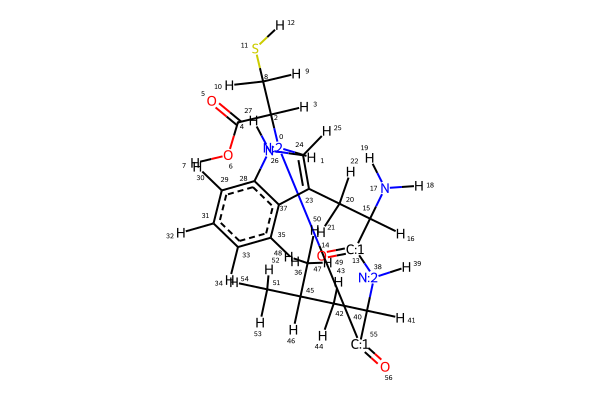

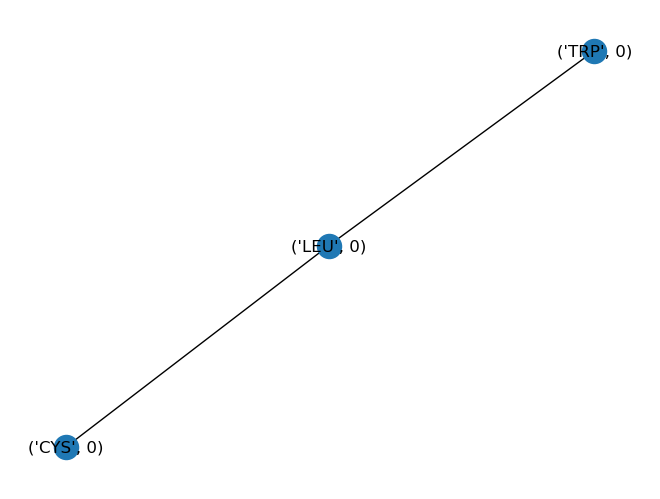

In [ ]:
# show contents of molecule
print(molecule_prim.hierarchy_summary(to_depth=1))
molecule_prim.visualize_topology()

rdmol = primitive_to_rdkit(molecule_prim)
display(rdmol)